In [8]:
import sys
sys.path.append('..')
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS 
import glob
import math
import re
from Clustering_Functions import *
from itertools import combinations
import itertools
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
filepath = '../ballot-clustering old versions'
dfK = pd.read_pickle(f'{filepath}/results_2025.pkl') # heuristic results
dfIP = pd.read_pickle(f'{filepath}/IP_results_v2.pkl') # IP results

In [3]:
len(dfIP)

8395

In [4]:
# count Scottish elections with fewer than 9 candidates
# and make dict mapping election name to number of candidates
full_filename_list = glob.glob("scot-elex/**/*.csv")
tally = 0
file_to_num_cands = {}
for full_filename in full_filename_list:
    filename = os.path.basename(full_filename)
    num_cands, election, cand_names, location = csv_parse(full_filename)
    file_to_num_cands[filename] = num_cands
    if num_cands < 9:
        tally +=1
print(tally)

842


In [5]:
print(dfK.columns)
print(dfIP.columns)

Index(['filename', 'num_cands', 'parties', 'method', 'block_size', 'sil',
       'cal', 'dav', 'centers', 'clustering'],
      dtype='object')
Index(['election', 'method', 'proxy', 'num_candidates', 'num_clusters',
       'centroids', 'ballots'],
      dtype='object')


In [6]:
print(dfIP['method'].unique())
print(dfIP['proxy'].unique())
print(dfK['method'].unique())

['continuous' 'continuous_rest' 'discrete']
['bordaa' 'bordap' 'hh']
['meanBC' 'meanBA' 'meanH' 'medoBC' 'medoBA' 'medoH' 'slate' 'slate_weak']


In [7]:
# create `df` dataframe to hold IP and heuristic results.
# add the IP results to df.

d_proxy = {'bordaa': 'BA', 'bordap': 'BP', 'hh': 'HH'}

df = pd.DataFrame(columns=['filename', 'num_cands', 'method', 'proxy', 'technique', 'centers', 'proxies_of_centers', 'clustering'])

for index in dfIP.index:
    filename = f"{dfIP['election'][index]}.csv" 
    num_cands = dfIP['num_candidates'][index]

    # test if the number of candidates is correct
    if num_cands != file_to_num_cands[filename]:
        print(f"{filename}:{num_cands}->{file_to_num_cands[filename]}")
        num_cands = file_to_num_cands[filename]
        
    proxies_of_centers = dfIP['centroids'][index]
    clustering = dfIP['ballots'][index]
    method = dfIP['method'][index]
    proxy = d_proxy[dfIP['proxy'][index]]
    technique = f"{method}_{proxy}"

    # if the proxy is 'BA', then the proxies_of_centers are off by 1.
    # if proxy == 'BA':
    #    proxies_of_centers = {i: tuple([x-1 for x in proxy]) for i, proxy in proxies_of_centers.items()} 

    t = df.shape[0]
    df.loc[t] = [filename, num_cands, method, proxy, technique, None, proxies_of_centers, clustering]

In [8]:
# test for center proxies that are the wrong length in the IP dataframe
problematic_proxies = set()
problematic_methods = set()
problematic_num_cands = set()

for index in dfIP.index:
    num_cands = dfIP['num_candidates'][index]
    filename = f'{dfIP["election"][index]}.csv'
    method = dfIP['method'][index]
    proxy = dfIP['proxy'][index]
    centroid_length = len(dfIP['centroids'][index][0])
    if proxy == 'hh':
        correct_length = (num_cands**2 - num_cands) // 2
    else:
        correct_length = num_cands
    if centroid_length != correct_length:
        print(f"{filename}, {method}, {proxy}: {centroid_length} -> {correct_length}")
        problematic_proxies.add(proxy)
        problematic_methods.add(method)
        problematic_num_cands.add(num_cands)

In [9]:
problematic_proxies, problematic_methods, problematic_num_cands

(set(), set(), set())

In [10]:
D = {'meanBA': ('Lloyd', 'BA'), 'meanBC': ('Lloyd', 'BP'), 'meanH': ('Lloyd', 'HH'), 
     'medoBA': ('PAM', 'BA'), 'medoBC': ('PAM', 'BP'), 'medoH': ('PAM', 'HH'), 'slate': ('slate', None)}

for index in dfK.index:
    filename = dfK['filename'][index] 
    num_cands = dfK['num_cands'][index]
    clustering = dfK['clustering'][index]
    m = dfK['method'][index]
    if m == 'slate_weak':
        continue
    method, proxy = D[m]
    technique = method if method == 'slate' else f"{method}_{proxy}"

    if method == 'Lloyd':
        proxies_of_centers_as_array = dfK['centers'][index]
        # multiply proxies by 2 because data is in the older format that used +-(1/2)
        proxies_of_centers = {0: 2*proxies_of_centers_as_array[0], 1: 2*proxies_of_centers_as_array[1]}
        centers = None
    else:
        centers = dfK['centers'][index]
        proxies_of_centers = None
    t = df.shape[0]
    df.loc[t] = [filename, num_cands, method, proxy, technique, centers, proxies_of_centers, clustering]

In [11]:
method_list = list(df['technique'].unique())
print(method_list)

['continuous_BA', 'continuous_BP', 'continuous_HH', 'continuous_rest_BA', 'continuous_rest_BP', 'continuous_rest_HH', 'discrete_BA', 'discrete_BP', 'discrete_HH', 'Lloyd_BP', 'Lloyd_BA', 'Lloyd_HH', 'PAM_BP', 'PAM_BA', 'PAM_HH', 'slate']


In [12]:
full_filename_list = glob.glob("scot-elex/**/*.csv")
#filename_list = [os.path.basename(x) for x in full_filename_list]

election_to_closssness = dict() # dictionary mapping the election filename to a dictionary mapping method pairs to closeness

common_filename_list = []
missing_data = []
for full_filename in full_filename_list:
    filename = os.path.basename(full_filename)
    num_cands, election, cand_names, location = csv_parse(full_filename)
    if len(df[df['filename'] == filename]) != len(method_list):
        if num_cands<9:
            missing_data.append(filename)
            # print(f"Missing data for {filename}")
        continue

    #print(filename)
    common_filename_list.append(filename)

    # create dictionary mapping method to clustering
    method_pair_to_clustering = dict()
    for method in method_list:
        df_row = df[(df['filename'] == filename) & (df['technique'] == method)]
        method_pair_to_clustering[method] = df_row['clustering'].values[0]

    # create dictionary mapping method pair to closeness
    pair_to_closeness = dict()
    for m1, m2 in combinations(method_list,2):
        C1 = method_pair_to_clustering[m1]
        C2 = method_pair_to_clustering[m2]
        pair_to_closeness[(m1,m2)] = Clustering_closeness(election,C1,C2) 

    election_to_closssness[filename] = pair_to_closeness

In [13]:
len(missing_data)

67

In [14]:
# print the missing method-election pairs
for filename in missing_data:
    test = df[df['filename'] == filename]['technique'].unique()
    num_cands = df[df['filename'] == filename]['num_cands'].unique()[0] 
    gone = set(method_list) - set(test)
    print(f"Missing methods from {filename} ({num_cands} cands): {gone}")

Missing methods from eilean_siar_2012_ward4.csv (7 cands): {'continuous_HH'}
Missing methods from eilean_siar_2012_ward5.csv (7 cands): {'continuous_HH', 'continuous_BA'}
Missing methods from eilean_siar_2022_ward10.csv (7 cands): {'continuous_BA'}
Missing methods from highland_2017_ward4.csv (7 cands): {'continuous_BA'}
Missing methods from highland_2017_ward8.csv (7 cands): {'continuous_BA'}
Missing methods from highland_2022_dingwall.csv (7 cands): {'continuous_BA'}
Missing methods from shetland_2012_ward7.csv (7 cands): {'continuous_BA'}
Missing methods from shetland_2022_ward6.csv (7 cands): {'continuous_HH', 'continuous_BA'}
Missing methods from aberdeenshire_2012_ward11.csv (8 cands): {'continuous_BA'}
Missing methods from aberdeenshire_2022_ward1.csv (8 cands): {'continuous_BA'}
Missing methods from aberdeenshire_2022_ward10.csv (8 cands): {'continuous_HH', 'continuous_BA'}
Missing methods from aberdeenshire_2022_ward18.csv (8 cands): {'continuous_HH', 'continuous_BA'}
Missing 

In [15]:
# make dataframe of average closeness of each pair of methods
avg_closeness = pd.DataFrame(columns=method_list, index=method_list)
for m1, m2 in combinations(method_list, 2):
    avg_closeness.loc[m1,m2] = np.mean([election_to_closssness[filename][(m1,m2)] for filename in common_filename_list])

# make it into a skey symmetric matrix
for m1, m2 in itertools.product(method_list, method_list):
    if m1 == m2:
        avg_closeness.loc[m1,m2] = 0
    elif pd.isna(avg_closeness.loc[m1,m2]):
        avg_closeness.loc[m1,m2] = avg_closeness.loc[m2,m1]

avg_closeness_rounded = avg_closeness.round(2)
avg_closeness_rounded

,continuous_BA,continuous_BP,continuous_HH,continuous_rest_BA,continuous_rest_BP,continuous_rest_HH,discrete_BA,discrete_BP,discrete_HH,Lloyd_BP,Lloyd_BA,Lloyd_HH,PAM_BP,PAM_BA,PAM_HH,slate
continuous_BA,0,0.048513,0.053374,0.132545,0.054578,0.084733,0.052241,0.055059,0.052378,0.054663,0.054825,0.053948,0.057091,0.057297,0.057882,0.125141
continuous_BP,0.048513,0,0.043188,0.144245,0.029332,0.084408,0.06727,0.030052,0.044574,0.063001,0.065606,0.064512,0.041211,0.072452,0.048778,0.130237
continuous_HH,0.053374,0.043188,0,0.133649,0.039931,0.085265,0.061398,0.039967,0.02919,0.06893,0.068678,0.066961,0.047269,0.064677,0.035052,0.137242
continuous_rest_BA,0.132545,0.144245,0.133649,0,0.191926,0.21455,0.156183,0.191217,0.179737,0.210306,0.206541,0.206353,0.190858,0.156793,0.179324,0.222857
continuous_rest_BP,0.054578,0.029332,0.039931,0.191926,0,0.093808,0.057354,0.001306,0.031447,0.076497,0.07919,0.078565,0.018562,0.063643,0.038568,0.143901
continuous_rest_HH,0.084733,0.084408,0.085265,0.21455,0.093808,0,0.10513,0.092608,0.093983,0.080087,0.081072,0.080983,0.09536,0.108058,0.096578,0.144456
discrete_BA,0.052241,0.06727,0.061398,0.156183,0.057354,0.10513,0,0.072137,0.065652,0.105541,0.104535,0.103614,0.075892,0.014224,0.068704,0.165702
discrete_BP,0.055059,0.030052,0.039967,0.191217,0.001306,0.092608,0.072137,0,0.030716,0.076184,0.078871,0.078247,0.017695,0.06299,0.037837,0.143786
discrete_HH,0.052378,0.044574,0.02919,0.179737,0.031447,0.093983,0.065652,0.030716,0,0.078253,0.078798,0.077447,0.040998,0.055809,0.011256,0.144124
Lloyd_BP,0.054663,0.063001,0.06893,0.210306,0.076497,0.080087,0.105541,0.076184,0.078253,0,0.014469,0.016227,0.063915,0.078699,0.063701,0.109089


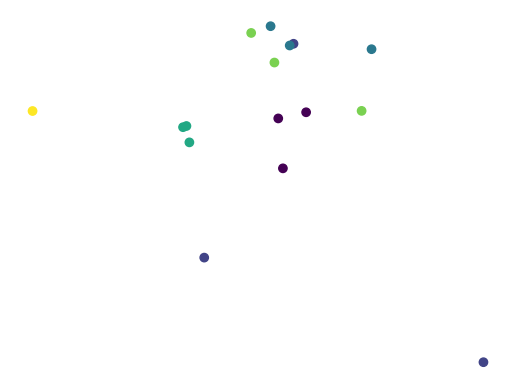

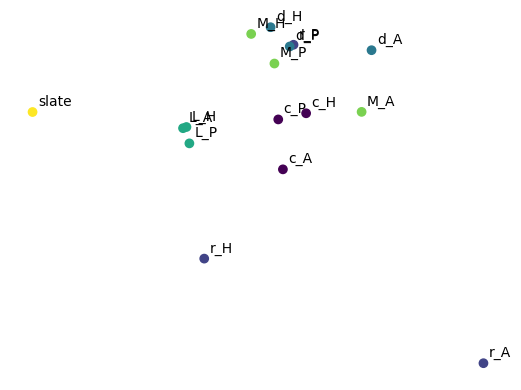

In [16]:
# Create MDS plot of the distances between the methods

short_names = ['c_A', 'c_P', 'c_H', 'r_A', 'r_P', 'r_H', 'd_A', 'd_P', 'd_H' ,'L_P', 'L_A', 'L_H', 'M_P', 'M_A', 'M_H', 'slate']
projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(avg_closeness)
X = np.array([p[0] for p in projections])
Y = np.array([p[1] for p in projections])

c = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5]
fig, ax = plt.subplots()
ax.scatter(X,Y, cmap='viridis',c = c)
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_unlabled", dpi = 600)
plt.show()

fig, ax = plt.subplots()
ax.scatter(X,Y,c = c)
for count in range(len(method_list)):
    ax.annotate(short_names[count], xy=(X[count]+.003, Y[count]+.003))
ax.grid(False)
ax.axis('off')
#plt.savefig("plots/method_MDS_labeled", dpi = 600)
plt.show()

In [2]:
def Reverse_Borda(proxy):
    """ 
    returns the ballot corresponding to the given Borda proxy vector,
    Works with any borda_style convention ('pes' or 'avg') 
    """
    ballot_length = len(set(proxy))-1
    l = []
    proxy = list(proxy)
    for count in range(ballot_length):
        cand = np.argmax(proxy)
        proxy[cand] = -1
        l.append(cand+1)
    return tuple(l)

In [3]:
def Reverse_HH(proxy):
    """ 
    returns the ballot corresponding to the given HH proxy vector
    """
    # determine the number of candidates
    proxy = list(proxy)
    A = np.sqrt(1+8*len(proxy))
    if not A.is_integer():
        raise ValueError("Invalid proxy vector")
    num_cands = int((1+A)/2)
    
    cand_pairs = list(combinations(range(1,num_cands+1),2))
    ballot = [num_cands] # initialize ballot: bullet vote for last candidate
    missing_from_ballot = [] # initialize list of candidates not on the ballot

    # We'll work through cand_pairs (i,j) in reverse order.  
    # For 5 candidates, the order is (4,5) | (3,5), (3,4) | (2,5), (2,4), (2,3) | (1,5), (1,4), (1,3), (1,2)
    # which breaks into groups for i = 4,3,2,1
    # for each group, we add i to the top of the ballot, and then use the rest of the group's information to reposition i correctly.
    while len(cand_pairs)>0:
        i,j = cand_pairs.pop()
        hh = proxy.pop()

        if hh == 0:
            missing_from_ballot.append(i)
            missing_from_ballot.append(j)
            if i in ballot:
                ballot.remove(i)
            if j in ballot:
                ballot.remove(j)
            continue

        if (not i in ballot) and (not i in missing_from_ballot):
            ballot.insert(0,i) # when i is first-encountered, insert i at top of ballot
        if i in missing_from_ballot or j in missing_from_ballot:
            continue # i is already correctly placed
        i_pos = ballot.index(i)
        j_pos = ballot.index(j)
        if (i_pos > j_pos) == (hh>0): # if i,j are out of order
            ballot.remove(i)
            ballot.insert(j_pos,i)
    return tuple(ballot)

In [19]:
# Find the centers whenever only the proxies of the centers are given
centers_list = []
for index in df.index:
    if df['centers'][index] == None:
        proxies_of_centers = df['proxies_of_centers'][index]
        if (df['proxy'][index] == 'BA') or (df['proxy'][index] == 'BP'):
            centers = {i:Reverse_Borda(proxy) for i,proxy in proxies_of_centers.items()}
        elif df['proxy'][index] == 'HH':
            centers = {i:Reverse_HH(proxy) for i,proxy in proxies_of_centers.items()}
    else:
        centers = df['centers'][index]
    centers_list.append(centers)

df['centers'] = centers_list

In [21]:
filepath = '../ballot-clustering old versions'
df.to_pickle(f'{filepath}results.pkl')
df = pd.read_pickle(f'{filepath}/results.pkl')

In [4]:
filepath = '../ballot-clustering old versions'
filepath = '..'
# df.to_pickle(f'{filepath}results.pkl')
df = pd.read_pickle(f'{filepath}/results.pkl')

In [6]:
df.columns

Index(['filename', 'num_cands', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers', 'cast_centers', 'score'],
      dtype='object')

In [21]:
# (for continuous_rest and discrete): verify that the centers match the proxies 
# (for continuous): for each proxy type, find portion of elections for which the proxies actually correpsond to ballots

good_counts = {proxy:0 for proxy in ['BA','BP','HH']}
bad_counts = {proxy:0 for proxy in ['BA','BP','HH']}
for index in df.index:
    method = df['method'][index]
    if not method in ['continuous', 'continuous_rest', 'discrete']:
        continue
    centers = df['centers'][index]
    proxies_of_centers = df['proxies_of_centers'][index]
    num_cands = df['num_cands'][index]
    proxy_type = df['proxy'][index]

    bad = False
    for i in [0,1]:
        ballot = centers[i]
        proxy_of_center = proxies_of_centers[i]
        if proxy_type == 'BA':
            correct_proxy = Borda_vector(ballot, num_cands, borda_style='avg')
        elif proxy_type == 'BP':
            correct_proxy = Borda_vector(ballot, num_cands, borda_style='pes')
        elif proxy_type == 'HH':
            correct_proxy = HH_proxy(ballot, num_cands)
            
        if list(proxy_of_center) != list(correct_proxy):
            if method == 'continuous':
                bad = True
            else:
                print(f"{num_cands},{method},{proxy_type}: {ballot} -> {list(correct_proxy)} != {list(proxy_of_center)}")
    if method == 'continuous':
        if bad:
            bad_counts[proxy_type] += 1
        else:
            good_counts[proxy_type] += 1

In [22]:
# portion of elections for which the continuous proxies actually correspond to ballots
{i:round(good_counts[i]/(good_counts[i]+bad_counts[i]), 2) for i in ['BA','BP','HH']}

{'BA': 0.05, 'BP': 0.1, 'HH': 0.39}

In [23]:
# for each proxy method, determine the portion of elections for which the continuous_rest centers 
# correspond to ballots that were actually cast in the election.
# create new column with a boolean value for whether both centers correspond to cast ballots
cast_centers = []
good_list = []
bad_list = []
good_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}
bad_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}
for index in df.index:
    method = df['method'][index]
    if method != 'continuous_rest':
        cast_centers.append(None)
        continue
    centers = df['centers'][index]
    num_cands = df['num_cands'][index]
    filename = df['filename'][index]
    full_filename = f"scot-elex/{num_cands}_cands/{filename}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    if centers[0] in election.keys() and centers[1] in election.keys():
        good_list.append(filename)
        good_counts[df['proxy'][index]] += 1
        cast_centers.append(True)
    else:
        bad_list.append(filename)
        bad_counts[df['proxy'][index]] += 1
        cast_centers.append(False)
df['cast_centers'] = cast_centers

In [24]:
# for each proxy, the portion of elections in which the continuous_rest centers correspond to ballots that were actually cast in the election
{i:round(good_counts[i]/(good_counts[i]+bad_counts[i]),2) for i in good_counts.keys()}

{'BA': 1.0, 'BP': 0.99, 'HH': 0.67}

In [25]:
# Among elections for which the continuous_rest centers correspond to ballots that were actually cast in the election,
# confirm that the centers match the centers from the corresponding discrete clustering

good_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}
bad_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}

for index in df.index:
    if df['method'][index] != 'continuous_rest' or df['cast_centers'][index] == False:
        continue
    filename = df['filename'][index]
    rest_centers = df['centers'][index]
    proxy = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'discrete_{proxy}')].index[0]
    discrete_centers = df['centers'][row_index]
    if set(rest_centers.values()) != set(discrete_centers.values()):
        print(f"{filename} ({proxy}): {rest_centers[0],rest_centers[1]} != {discrete_centers[0],discrete_centers[1]}")
        bad_counts[proxy] += 1
    else:
        good_counts[proxy] += 1

aberdeen_2022_ward11.csv (BA): ((5,), (1,)) != ((1,), (5, 2, 3))
aberdeenshire_2012_ward10.csv (BA): ((2,), (4,)) != ((1, 3), (2,))
aberdeenshire_2012_ward1.csv (BA): ((5,), (1,)) != ((1, 2), (5,))
aberdeenshire_2012_ward13.csv (BA): ((2,), (3,)) != ((1, 2), (3, 4))
aberdeenshire_2012_ward15.csv (BA): ((2,), (5,)) != ((2,), (5, 1, 3))
aberdeenshire_2012_ward16.csv (BA): ((3,), (2,)) != ((2,), (3, 1))
aberdeenshire_2017_ward15.csv (BA): ((3,), (2,)) != ((2,), (3, 1))
aberdeenshire_2017_ward4.csv (BA): ((2,), (1,)) != ((1, 5, 4), (2, 3))
aberdeenshire_2017_ward7.csv (BA): ((5,), (2,)) != ((2,), (5, 4))
aberdeenshire_2017_ward9.csv (BA): ((4,), (5,)) != ((4, 1), (5, 2))
aberdeenshire_2022_ward2.csv (BA): ((2,), (3,)) != ((3, 4), (2, 5, 1))
angus_2017_ward4.csv (BA): ((2,), (1,)) != ((1, 3), (2, 5))
angus_2017_ward6.csv (BA): ((3,), (2,)) != ((2, 5), (3, 1, 4))
angus_2022_ward2.csv (BA): ((5,), (3,)) != ((3,), (5, 4, 1, 2))
argyll_bute_2017_ward10.csv (BA): ((4,), (1,)) != ((1,), (4, 3, 2,

In [26]:
# portion of the elections for which the continuous_rest centers match the centers from the corresponding discrete clustering
{i:round(good_counts[i]/(good_counts[i]+bad_counts[i]),2) for i in good_counts.keys()}

{'BA': 0.02, 'BP': 1.0, 'HH': 0.0}

In [27]:
df['technique'].unique()

array(['continuous_BA', 'continuous_BP', 'continuous_HH',
       'continuous_rest_BA', 'continuous_rest_BP', 'continuous_rest_HH',
       'discrete_BA', 'discrete_BP', 'discrete_HH', 'Lloyd_BP',
       'Lloyd_BA', 'Lloyd_HH', 'PAM_BP', 'PAM_BA', 'PAM_HH', 'slate'],
      dtype=object)

In [28]:
def Cluster_from_given_centers(election, centers, proxy_type, order=1, centers_live_in_proxy_space = False):
    """
    Given the centers, cluster the ballots according to their closest center
    and return the summed distance and the clustering.
    ARGS:
        election: dictionary mapping ballots to weights
        centers: dictionary mapping center index to ballot or ballot proxy
        proxy_type: one of {'BA', 'BP', 'HH'} for Borda average, Borda pessimistic, or HH proxy
        order: the choice of p for L^p distance.  Use 1 for Manhattan, 2 for Euclidean.
        centers_live_in_proxy_space: True if the centers are in proxy space, False if they are in ballot space
    RETURNS:
        (summed distance, clustering)
        summed distance = sum of L^p distances from each ballot to its closest center
        clustering = dictionary mapping index to cluster.
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])
    k = len(centers)

    C = {i:dict() for i in range(k)} # initialize clustering
    running_sum = 0
    for ballot, weight in election.items():
        if centers_live_in_proxy_space:
            if proxy_type == 'BA':
                ballot_proxy = Borda_vector(ballot, num_cands, borda_style='avg')
            elif proxy_type == 'BP':
                ballot_proxy = Borda_vector(ballot, num_cands, borda_style='pes')
            elif proxy_type == 'HH':
                ballot_proxy = HH_proxy(ballot, num_cands)
            dists = [(1/2)*np.linalg.norm(ballot_proxy - centers[i],ord=order) for i in centers.keys()]
        else:
            if proxy_type == 'BA':
                dists = [Borda_dist(ballot, centers[i], num_cands, borda_style='avg', order=order) for i in centers.keys()]
            elif proxy_type == 'BP':
                dists = [Borda_dist(ballot, centers[i], num_cands, borda_style='pes', order=order) for i in centers.keys()]
            elif proxy_type == 'HH':
                dists = [HH_dist(ballot, centers[i], num_cands, order=order) for i in centers.keys()]

        running_sum += weight*np.min(dists)
        clusts = [x for x in range(k) if dists[x]==np.min(dists)] # multi-valued argmin
        for clust in clusts:
            C[clust][ballot]=weight/len(clusts)
    return running_sum, C

In [29]:
# Compute the score (summed L^1 distance of the ballots to the nearest center) for all the methods and all proxies.
score_list = []
for index in df.index:
    method = df['method'][index]
    if method == 'slate':
        score_list.append(None)
        continue
    election = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"scot-elex/{num_cands}_cands/{election}"
    num_cands, election, cand_names, ward = csv_parse(full_filename)
    proxy_type = df['proxy'][index]
    if method in ['continuous', 'continuous_rest', 'discrete', 'Lloyd']:
        centers = df['proxies_of_centers'][index]
        centers_live_in_proxy_space = True
    else: # method == 'PAM':
        centers = df['centers'][index]
        centers_live_in_proxy_space = False
    order = 2 if method == 'Lloyd' else 1
    score, clustering = Cluster_from_given_centers(election, centers, proxy_type, order, centers_live_in_proxy_space)
    score_list.append(score)
df['score'] = score_list

In [30]:
# Verify with discrete and continuous_rest that the same scores are obtained using center_live_in_proxy_space = False
for index in df.index:
    method = df['method'][index]
    if not method in ['continuous_rest', 'discrete']:
        continue
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    full_filename = f"scot-elex/{num_cands}_cands/{filename}"
    _, election, cand_names, ward = csv_parse(full_filename)
    proxy_type = df['proxy'][index]
    centers = df['centers'][index]
    centers_live_in_proxy_space = False
    order = 1
    score, clustering = Cluster_from_given_centers(election, centers, proxy_type, order, centers_live_in_proxy_space)
    if score != df['score'][index]:
        print(f"({num_cands}){filename}({method}_{proxy_type}): {score} != {df['score'][index]}")

In [45]:
df.to_pickle(f'{filepath}/results.pkl')

In [23]:
df = df.drop(columns=['clustering'])

In [25]:
df.to_pickle('merged.pkl')

In [31]:
# find portion of elections for which the discrete centers match the PAM centers
# when they don't, check that the discrete centers score better.
good_count = 0
bad_count = 0
very_bad_count = 0
row_index = 0
for index in df.index:
    if df['method'][index] != 'discrete':
        continue
    discrete_centers = df['centers'][index]
    discrete_score = df['score'][index]
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}')].index[0]
    PAM_score = df['score'][row_index]
    PAM_centers = df['centers'][row_index]
    if set(PAM_centers.values()) == set(discrete_centers.values()):
        good_count += 1
    else:
        bad_count += 1
        if PAM_score < discrete_score:
           very_bad_count += 1

In [32]:
# portion of elections for which the discrete centers match the PAM centers
# (and verification that the discrete centers score better when they don't)
good_count/(good_count + bad_count), very_bad_count

(0.9243055555555556, 0)

In [33]:
# determine the portion of the elections for which the PAM centers beat the continuous centers
good_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}
bad_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}

for index in df.index:
    if df['method'][index] != 'continuous':
        continue
    filename = df['filename'][index]
    proxy_type = df['proxy'][index]
    continuous_score = df['score'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}')].index[0]
    PAM_score = df['score'][row_index]

    if PAM_score < continuous_score:
        #print(f"{filename} ({proxy_type})")
        bad_counts[proxy_type] += 1
    else:
        good_counts[proxy_type] += 1

In [34]:
# portion of the elections for which the continuous centers are better than PAM
{i:round(good_counts[i]/(good_counts[i]+bad_counts[i]),2) for i in good_counts.keys()}

{'BA': 1.0, 'BP': 1.0, 'HH': 0.93}

In [35]:
# identify particular elections for which the PAM_HH centers beat the continuous_HH centers
continuous_HH_problems = pd.DataFrame(columns=['filename', 'num_cands', 'IP proxies', 'IP score', 'PAM proxies', 'PAM score'])

for index in df.index:
    if df['method'][index] != 'continuous':
        continue
    if df['proxy'][index] != 'HH':
        continue
    filename = df['filename'][index]
    continuous_score = df['score'][index]
    num_cands = df['num_cands'][index]
    continuous_proxies = df['proxies_of_centers'][index]
    proxy_type = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}')].index[0]
    PAM_proxies = df['centers'][row_index]
    PAM_score = df['score'][row_index]

    if PAM_score < continuous_score:
        row_index = continuous_HH_problems.shape[0]
        continuous_HH_problems.loc[row_index] = [filename, num_cands, continuous_proxies, continuous_score, PAM_proxies, PAM_score]

In [36]:
len(continuous_HH_problems)

57

In [37]:
continuous_HH_problems.to_csv('continuous_HH_problems.csv')
continuous_HH_problems.to_pickle('continuous_HH_problems.pkl')

In [38]:
# count and identify elections for which the PAM centers beat the continuous_rest centers

good_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}
bad_counts = {proxy:0 for proxy in ['BA', 'BP', 'HH']}

continuous_rest_problems = pd.DataFrame(columns=['filename', 'num_cands', 'proxy_type','IP proxies', 'IP score', 'PAM proxies', 'PAM score'])
row_index = 0
for index in df.index:
    if df['method'][index] != 'continuous_rest':
        continue
    filename = df['filename'][index]
    num_cands = df['num_cands'][index]
    IP_proxies = df['proxies_of_centers'][index]
    IP_score = df['score'][index]
    proxy_type = df['proxy'][index]
    row_index = df[(df['filename'] == filename) & (df['technique'] == f'PAM_{proxy_type}')].index[0]
    PAM_centers = df['centers'][row_index]
    PAM_score = df['score'][row_index]

    if PAM_score < IP_score:
        #print(f"{filename} ({num_cands} cands, {proxy_type}): {IP_score} -> {PAM_score}")
        continuous_rest_problems.loc[row_index] = [filename, num_cands, proxy_type, IP_proxies, IP_score, PAM_proxies, PAM_score]
        row_index += 1
        bad_counts[proxy_type] += 1
    else:
        good_counts[proxy_type] += 1

In [46]:
# portion of the elections for which the continuous_rest centers are better than PAM 
{i:round(good_counts[i]/(good_counts[i]+bad_counts[i]),2) for i in good_counts.keys()}

{'BA': 0.03, 'BP': 1.0, 'HH': 0.0}

In [40]:
continuous_rest_problems.to_csv('continuous_rest_problems_2.csv')
continuous_rest_problems.to_pickle('continuous_rest_problems_2.pkl')

In [41]:
len(continuous_rest_problems)

1894

In [42]:
len(continuous_rest_problems[continuous_rest_problems['proxy_type'] == 'BP'])

0

In [47]:
df['method'].unique()

array(['continuous', 'continuous_rest', 'discrete', 'Lloyd', 'PAM',
       'slate'], dtype=object)

In [50]:
# Verify that the scores of the methods (all with BP proxies) are ordered as expected:
# Lloyd <= continuous <= continuous_rest <= discrete <= PAM
missing_count = 0
good_count = 0
for index in df.index:
    technique = df['technique'][index]
    if technique !='discrete_BP':
        continue
    score_dict = {m:0 for m in ['Lloyd', 'continuous', 'continuous_rest', 'discrete', 'PAM']}
    filename = df['filename'][index]
    score_dict['discrete'] = df['score'][index]
    for method in ['Lloyd', 'continuous', 'continuous_rest', 'PAM']:
        filtered_df = df[(df['filename'] == filename) & (df['technique'] == f'{method}_BP')]
        if len(filtered_df) == 0:
            missing_count += 1
            print(f"{filename}: missing {method}")
            continue
        row_index = filtered_df.index[0]
        score_dict[method] = df['score'][row_index]

    if not (score_dict['continuous'] <= score_dict['continuous_rest'] <= score_dict['discrete'] <= score_dict['PAM']):
        print(f"{filename}: {score_dict}")
    else:
        good_count += 1

orkney_2012_ward4.csv: missing continuous


In [49]:
good_count, missing_count

(960, 1)

In [10]:
# The Pentland Hills election that's studied in the paper
full_filename = '../scot-elex/7_cands/edinburgh_2017_ward2.csv'
filename = os.path.basename(full_filename)
num_cands, election, cand_names, ward = csv_parse(full_filename)
parties = party_abrevs(cand_names)
dfPH = df[df['filename'] == filename].copy()

In [20]:
# print Pentland Hills centers
center_dict = {}
for index in dfPH.index:
    technique = dfPH['technique'][index]
    method = dfPH['method'][index]
    proxy_type = dfPH['proxy'][index]
    if method == 'continuous_rest':
        continue
    centers = dfPH['centers'][index]
    if method == 'continuous':
        center_dict[proxy_type] = centers

    print(f"{technique}: {centers[0]}, {centers[1]}")
print('Continuous_HH: (1,6), inconsistent')

continuous_BA: (1, 6), (3, 5, 7, 2)
continuous_BP: (1,), (3, 5, 7)
continuous_HH: (1, 6), (3, 5)
discrete_BA: (1, 6), (3, 5, 7)
discrete_BP: (1, 6), (3, 5, 7, 4)
discrete_HH: (1, 6), (3, 5, 4)
Lloyd_BP: (1, 6, 4, 2, 7, 3), (3, 5, 4, 7, 2, 1)
Lloyd_BA: (3, 5, 4, 7, 2, 1), (1, 6, 4, 2, 7, 3)
Lloyd_HH: (3, 5, 4, 7, 2, 1, 6), (1, 6, 4, 2, 7, 3, 5)
PAM_BP: (3, 5, 7, 4), (1, 6)
PAM_BA: (3, 5, 7), (1, 6)
PAM_HH: (1, 6), (3, 5, 4)
slate: (1, 6), (2, 3, 4, 5, 7)
Continuous_HH: (1,6), inconsistent


In [18]:
# print proxies of centers
proxy_dict = {}
for index in dfPH.index:
    technique = dfPH['technique'][index]
    method = dfPH['method'][index]
    proxy_type = dfPH['proxy'][index]
    centers = dfPH['centers'][index]
    proxies = dfPH['proxies_of_centers'][index]
    proxy = dfPH['proxy'][index]
    method = dfPH['method'][index]
    if method == 'continuous':
        proxy_dict[proxy_type] = proxies 
    if method in ['Lloyd', 'slate'] or proxies == None:
        continue
    print(f"{technique}: {proxies[0]}, {proxies[1]}")

continuous_BA: (5.0, 2.0, 2.0, 2.5, 2.0, 5.0, 2.0), (1.5, 2.0, 6.0, 2.0, 5.0, 1.5, 3.0)
continuous_BP: (5.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), (0.0, 0.0, 5.0, 2.0, 5.0, 0.0, 4.0)
continuous_HH: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0), (0.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 0.0, 1.0, 1.0, -1.0)
continuous_rest_BA: (6.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5), (2.5, 2.5, 6.0, 2.5, 2.5, 2.5, 2.5)
continuous_rest_BP: (6.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0), (0.0, 0.0, 6.0, 3.0, 5.0, 0.0, 4.0)
continuous_rest_HH: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0), (-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0)
discrete_BA: (6.0, 2.0, 2.0, 2.0, 2.0, 5.0, 2.0), (1.5, 1.5, 6.0, 1.5, 5.0, 1.5, 4.0)
discrete_BP: (6, 0, 0, 0, 0, 5, 0), (0, 0, 6, 3, 5, 0, 4)

In [22]:
center_dict

{'BA': {0: (1, 6), 1: (3, 5, 7, 2)},
 'BP': {0: (1,), 1: (3, 5, 7)},
 'HH': {0: (1, 6), 1: (3, 5)}}

In [27]:
b0 = center_dict['BA'][0]
v0 = Borda_vector(b0, num_cands = 7, borda_style='avg')
print(b0)
print(v0)
print(proxy_dict['BA'][0])

(1, 6)
[6. 2. 2. 2. 2. 5. 2.]
(5.0, 2.0, 2.0, 2.5, 2.0, 5.0, 2.0)


In [29]:
Reverse_Borda(proxy_dict['BA'][0])

(1, 6)

In [16]:
dfPH.columns

Index(['filename', 'num_cands', 'method', 'proxy', 'technique', 'centers',
       'proxies_of_centers', 'cast_centers', 'score'],
      dtype='object')

In [54]:
centers1 = {0:(1,), 1:(3,)} # centers for continuous_rest_BA
score1, C = Cluster_from_given_centers(election, centers1, 'BA', order = 1, centers_live_in_proxy_space = False)
print(score1)

centers2 = {0:(1, 6), 1:(3, 5, 7)}  # centers for PAM_BA 
score2, C = Cluster_from_given_centers(election, centers2, 'BA', order = 1, centers_live_in_proxy_space = False)
print(score2)

49496.0
37822.0


In [149]:
proxies1 = {0: (5.0, 2.0, 2.0, 2.5, 2.0, 5.0, 2.0), 1: (1.5, 2.0, 6.0, 2.0, 5.0, 1.5, 3.0)} # proxies for continuous_BA
score1, C = Cluster_from_given_centers(election, proxies1, 'BA', order = 1, centers_live_in_proxy_space = True)
print(score1)

proxies2 = {0: (6,2,2,2,2,5,2), 1: (1.5, 1.5, 6, 1.5, 5, 1.5, 4)} # proxies for PAM_BA
score2, C = Cluster_from_given_centers(election, proxies2, 'BA', order = 1, centers_live_in_proxy_space = True)
print(score2)

72863.5
75644.0


In [148]:
centers1 = {0:(1, 6, 4, 2, 7, 3, 5), 1:(3, 5, 7, 4, 2, 6, 1)} # centers for continuous_rest_HH
score1, C = Cluster_from_given_centers(election, centers1, 'HH', order = 1, centers_live_in_proxy_space = False)
print(score1)

centers2 = {0:(1, 6), 1:(3, 5, 4)}  # centers for PAM_HH 
score2, C = Cluster_from_given_centers(election, centers2, 'HH', order = 1, centers_live_in_proxy_space = False)
print(score2)

62606.0
49060.0
